In [ ]:
import wandb, json
import pandas as pd
import numpy as np
import os
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from pathlib import Path
import plotly.express as px

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["xtick.major.pad"] = 20
plt.rcParams["ytick.major.pad"] = 20
plt.rcParams["axes.labelpad"] = 20
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlepad"] = 40
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 60
plt.rcParams["legend.borderpad"] = 1
os.environ["WANDB_SILENT"] = "true"
entity_name = "louis-jalouzot"
project_name = "fMRI-Decoding-wrap-up"
api = wandb.Api(
    timeout=100, overrides={"project": project_name, "entity": entity_name}
)
global_run = wandb.init()
sns.set_context("poster")
sns.set_style("ticks")

# Utils

In [ ]:
def fetch_artifact(name, split, fold):
    artifact = f"louis-jalouzot/fMRI-Decoding-wrap-up/run-{name}-"
    if fold is not None:
        artifact += f"fold_{fold}"
    artifact += f"{split}metrics:latest"
    artifact = global_run.use_artifact(artifact, type="run_table")
    artifact_dir = artifact.download()
    if fold is not None:
        artifact_dir += f"/fold_{fold}"
    artifact_dir += f"/{split}/metrics.table.json"
    with open(artifact_dir) as f:
        metrics = json.load(f)

    return metrics


def load_split_folds(name, splits="test", n_folds=15):
    df = []
    if isinstance(splits, str):
        splits = [splits]
    if n_folds is not None:
        total = n_folds * len(splits)
    else:
        total = len(splits)

    with tqdm(total=total) as pbar:
        for split in splits:
            if n_folds is not None:
                for fold in range(1, n_folds + 1):
                    metrics = fetch_artifact(name, split, fold)
                    df.append(
                        pd.DataFrame(
                            metrics["data"], columns=metrics["columns"]
                        )
                    )
                    pbar.update(1)
            else:
                metrics = fetch_artifact(name, split, None)
                df.append(
                    pd.DataFrame(metrics["data"], columns=metrics["columns"])
                )
                pbar.update(1)

    return pd.concat(df)

In [ ]:
def get_baseline():
    baseline_path = Path("figs/baseline.csv.gz")
    if baseline_path.exists():
        return pd.read_csv("figs/baseline.csv.gz")
    else:
        baseline = load_split_folds(
            name="33582f283c354ab9f545ab5c4cd8866fc46b8fc6",
            splits=["train", "valid", "test"],
            n_folds=None,
        )  # random baseline
        baseline.to_csv(baseline_path, index=False)
        return baseline

# Decoding performance

## Setup

In [ ]:
df_path = Path("figs/setup_df.csv.gz")
if df_path.exists():
    df = pd.read_csv(df_path)
else:
    df = []
    runs = api.runs(filters={"tags": {"$in": ["setup_v3"]}})
    for run in tqdm(runs):
        if run._state == "finished":
            run_data = run.config | run.summary._json_dict
            df.append(pd.json_normalize(run_data))
    df = pd.concat(df)
    df.to_csv(df_path, index=False)

In [ ]:
baseline = get_baseline()
baseline = (
    baseline.drop_duplicates(["run", "tr"])
    .groupby("run")
    .top_10_accuracy.mean()
    .reset_index(name="Top 10 Accuracy")
)
baseline["Setup"] = "Random"

In [ ]:
df["model"] = df["latents_cfg.model"].replace(
    {
        "bert-base-uncased": "BERT",
        "McGill-NLP/LLM2Vec-Meta-Llama-31-8B-Instruct-mntp-unsup-simcse": "LLM2Vec",
    }
)

In [ ]:
cols = [
    col
    for col in df
    if "top_10_accuracy" in col
    and "test" in col
    and "fold" in col
    and "fmriprep" in col
]
id_vars_desc = {
    "latents_cfg.context_length": "+ Context Length",
    "alignment_cfg.lag": "+ Lag",
    "alignment_cfg.smooth": "+ Smooth",
    "model": "BERT $\\rightarrow$ LLM2Vec",
    "wrapper_cfg.loss": "MSE Loss $\\rightarrow$ Contrastive Loss",
    "decoder_cfg.class": "Simple MLP $\\rightarrow$ BrainDecoder",
}
id_vars = id_vars_desc.keys()
tmp = df.melt(
    id_vars=id_vars,
    value_vars=cols,
    value_name="Top 10 Accuracy",
).dropna()

In [ ]:
cols = {col: tmp[col].unique() for col in id_vars}
cols["model"] = ["BERT", "LLM2Vec"]
setup = {col: l[0] for col, l in cols.items()}
setup["Setup"] = "Base"
setups = [setup.copy()]
for col, l in cols.items():
    setup[col] = l[1]
    setup["Setup"] = id_vars_desc[col]
    setups.append(setup.copy())
setups = pd.DataFrame(setups).merge(tmp)
setups = pd.concat([baseline, setups])

In [ ]:
ax = sns.barplot(
    data=setups,
    y="Setup",
    x="Top 10 Accuracy",
    hue="Setup",
    legend=None,
    palette="Blues",
)
ax.set_xlim(-0.005, ax.get_xlim()[1])
ax.set_ylabel("")
ax.xaxis.set_major_locator(ticker.LinearLocator(4))
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, _: f"{int(100 * y)}%")
)
# plt.title("Setup comparison")
sns.despine(offset=20, trim=True)
plt.savefig("paper/figs/setup.pdf", bbox_inches="tight", pad_inches=0)

## Performance

In [ ]:
df_path = Path("figs/increase_data_df.csv.gz")
if df_path.exists():
    df = pd.read_csv(df_path)
else:
    df = []
    df_sizes = []
    runs = api.runs(filters={"tags": {"$in": ["increase_data_v2"]}})
    for run in tqdm(runs):
        if run._state == "finished":
            run_data = run.config | run.summary._json_dict
            df.append(pd.json_normalize(run_data))
    df = pd.concat(df)
    df.to_csv(df_path, index=False)

In [ ]:
metric_cols = [
    col
    for col in df
    if "fold" in col
    and "test" in col
    and "top_10_accuracy" in col
    and "lebel2023" in col
]
tmp = df.melt(
    id_vars=["train/n_trs", "train/size"],
    value_vars=metric_cols,
    value_name="Top 10 Accuracy",
)
tmp["Subject"] = (
    tmp.variable.str.split("/")
    .apply(lambda x: x[-2])
    .str.replace("lebel2023_fmriprep_UTS0", "")
)
tmp["Number of training samples"] = tmp[["train/n_trs", "train/size"]].max(
    axis=1
)
tmp = tmp.dropna(subset=["Top 10 Accuracy"])

In [ ]:
max_train_size = tmp["Number of training samples"].max()
print(max_train_size * 2 // 60 / 60)
print(
    tmp[tmp["Number of training samples"] == max_train_size]
    .groupby("Subject")["Top 10 Accuracy"]
    .mean()
    .mean()
)
tmp[tmp["Number of training samples"] == max_train_size].groupby("Subject")[
    "Top 10 Accuracy"
].mean().max()

In [ ]:
tmp_ = tmp[tmp.Subject.astype(int) > 3]
tmp_ = tmp_.merge(tmp_.groupby("Subject")["Number of training samples"].max())
print((tmp_["Number of training samples"] * 2 // 60 / 60).max())
tmp_ = tmp_.groupby("Subject")["Top 10 Accuracy"].mean()
print(tmp_.mean())
print(tmp_)

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    tmp,
    x="Number of training samples",
    y="Top 10 Accuracy",
    hue="Subject",
)
plt.xscale("log")
# plt.yscale("log")
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, _: f"{int(100 * y)}%")
)
ticklabels = ax.get_xticklabels()
for label in ticklabels:
    n_mins = (label.get_position()[0] * 2) // 60
    n_mins = n_mins // 10 * 10
    if n_mins > 60:
        n_mins = n_mins // 60
        label.set_text(label.get_text() + f"\n$\sim$ {n_mins:.0f} hours")
    else:
        label.set_text(label.get_text() + f"\n$\sim$ {n_mins:.0f} min")
ax.set_xticklabels(ticklabels)
plt.legend(
    title="Subject",
    loc="best",
    ncol=4,
    handlelength=1,
    labelspacing=0.2,
    columnspacing=0.5,
)
sns.despine(offset=10)
plt.title("Impact of the amount of training data")
plt.savefig("paper/figs/increase_data.pdf", bbox_inches="tight", pad_inches=0)

# Multi-subject

## Increase subjects

In [25]:
df_path = Path("figs/increase_subjects_df.csv.gz")
if df_path.exists():
    df = pd.read_csv(df_path)
else:
    df = []
    runs = api.runs(
        filters={"tags": {"$in": ["increase_subjects_balanced_v2"]}}
    )
    for run in tqdm(runs):
        if run._state == "finished":
            run_data = run.config | run.summary._json_dict
            df.append(pd.json_normalize(run_data))
    df = pd.concat(df)
    df["n_subjects"] = df["subjects.lebel2023_fmriprep_balanced"].apply(len)
    df["subjects.lebel2023_fmriprep_balanced"] = df[
        "subjects.lebel2023_fmriprep_balanced"
    ].astype(str)
    df.to_csv(df_path, index=False)

In [26]:
cols = [
    col
    for col in df
    if "top_10_accuracy" in col
    and "test" in col
    and "fold" in col
    and "fmriprep" in col
]
tmp = df.melt(
    id_vars=[
        "n_subjects",
        "wrapper_cfg.hidden_dim",
        "subjects.lebel2023_fmriprep_balanced",
    ],
    value_vars=cols,
    value_name="Top 10 Accuracy",
    var_name="subject",
)
tmp["fold"] = (
    tmp.subject.str.split("/")
    .apply(lambda x: x[0])
    .str.split("_")
    .apply(lambda x: x[-1])
)
tmp["subject"] = (
    tmp.subject.str.split("/")
    .apply(lambda x: x[-2])
    .str.split("_")
    .apply(lambda x: x[-1])
    .str.replace("UTS0", "")
)
tmp = tmp.dropna()

In [27]:
single_perfs = tmp[tmp.n_subjects == 1][
    ["wrapper_cfg.hidden_dim", "subject", "fold", "Top 10 Accuracy"]
]
tmp = tmp.merge(
    single_perfs,
    on=["wrapper_cfg.hidden_dim", "subject", "fold"],
    suffixes=("", " single"),
)
tmp["Multi - single\nTop 10 Accuracy"] = (
    tmp["Top 10 Accuracy"] - tmp["Top 10 Accuracy single"]
)

In [28]:
combi_scores = tmp.groupby(
    [
        "subject",
        "wrapper_cfg.hidden_dim",
        "subjects.lebel2023_fmriprep_balanced",
        "n_subjects",
    ]
)["Top 10 Accuracy"].mean()
best_combis = combi_scores.groupby(
    ["subject", "n_subjects", "wrapper_cfg.hidden_dim"]
).idxmax()
best_combis = (
    combi_scores[best_combis].reset_index().drop(columns="Top 10 Accuracy")
)
tmp = tmp.merge(best_combis)

/tmp/ipykernel_142549/3658916650.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


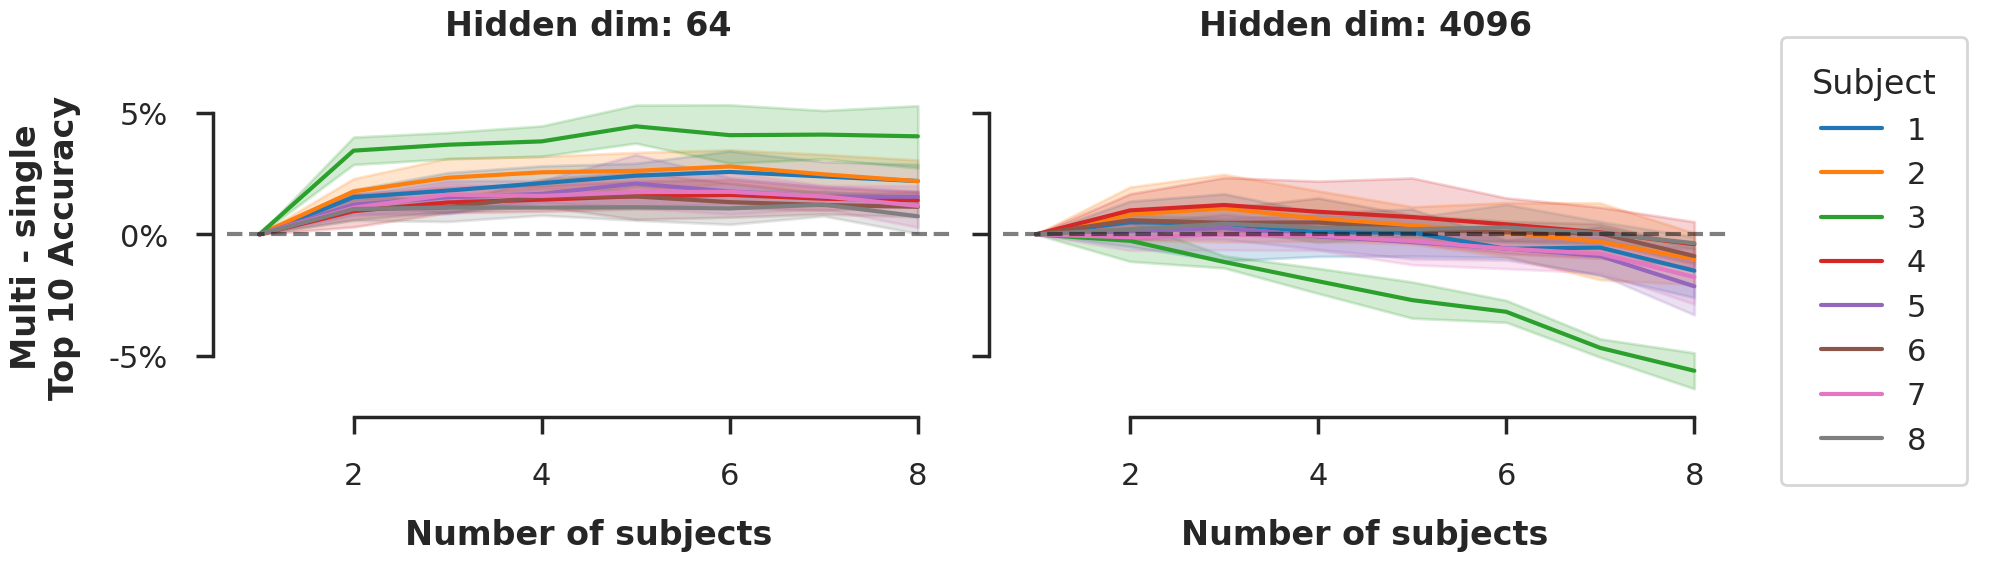

In [30]:
g = sns.relplot(
    data=tmp,
    x="n_subjects",
    y="Multi - single\nTop 10 Accuracy",
    hue="subject",
    kind="line",
    col="wrapper_cfg.hidden_dim",
    height=6,
    aspect=1.5,
    palette="tab10",
    legend="full",
)
g.axes[0, 0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, _: f"{int(100 * y)}%")
)
g.set_titles("Hidden dim: {col_name}")
g.set_axis_labels("Number of subjects")
sns.despine(offset=10, trim=True)
g.legend.set(
    title="Subject",
    bbox_to_anchor=(1, 0.5),
    loc="center right",
    frame_on=True,
)
plt.legend(
    bbox_to_anchor=(1.3, 1), loc="upper left", borderaxespad=0.0, frameon=False
)
for ax in g.axes.flat:
    ax.axhline(0, ls="--", color="black", alpha=0.5)
plt.savefig(
    "paper/figs/increase_subjects.pdf", bbox_inches="tight", pad_inches=0
)

## Overlap

In [ ]:
df_path = Path("figs/overlap_v2_df.csv.gz")
if df_path.exists():
    df = pd.read_csv(df_path)
else:
    df = []
    runs = api.runs(filters={"tags": {"$in": ["overlap_v2"]}})
    for run in tqdm(runs):
        if run._state == "finished":
            run_data = run.config | run.summary._json_dict
            df.append(pd.json_normalize(run_data))
    df = pd.concat(df)
    df["n_subjects"] = df["subjects.lebel2023_fmriprep"].apply(len)
    df["subjects.lebel2023_fmriprep"] = df[
        "subjects.lebel2023_fmriprep"
    ].astype(str)
    df.to_csv(df_path, index=False)

In [ ]:
cols = [
    col
    for col in df
    if "top_10_accuracy" in col
    and "test" in col
    and "fold" in col
    and "fmriprep" in col
]
tmp = df.melt(
    id_vars=[
        "n_subjects",
        "wrapper_cfg.hidden_dim",
        "splitting.overlap",
        "subjects.lebel2023_fmriprep",
    ],
    value_vars=cols,
    value_name="Top 10 Accuracy",
    var_name="subject",
)
tmp["fold"] = (
    tmp.subject.str.split("/")
    .apply(lambda x: x[0])
    .str.split("_")
    .apply(lambda x: x[-1])
)
tmp["subject"] = (
    tmp.subject.str.split("/")
    .apply(lambda x: x[-2])
    .str.split("_")
    .apply(lambda x: x[-1])
    .str.replace("UTS0", "")
)
tmp = tmp[(tmp.n_subjects > 1) + (tmp["splitting.overlap"] == 1)]
tmp = tmp.dropna()
single_subject = tmp[tmp.n_subjects == 1][
    ["wrapper_cfg.hidden_dim", "subject", "fold", "Top 10 Accuracy"]
]
tmp = tmp.merge(
    single_subject,
    on=["wrapper_cfg.hidden_dim", "subject", "fold"],
    suffixes=("", " single"),
)
tmp["Top 10 Accuracy"] = tmp["Top 10 Accuracy"] - tmp["Top 10 Accuracy single"]
tmp = tmp[tmp.n_subjects == 3]

In [ ]:
tmp.groupby(["subject", "wrapper_cfg.hidden_dim", "splitting.overlap"]).count()

In [ ]:
g = sns.relplot(
    data=tmp,
    x="splitting.overlap",
    y="Top 10 Accuracy",
    kind="line",
    col="wrapper_cfg.hidden_dim",
    hue="subject",
    height=6,
    aspect=1.5,
    hue_order=sorted(tmp.subject.unique()),
)
g.axes[0, 0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, _: f"{int(round(100 * y,0))}%")
)
g.set_axis_labels("Stimuli overlap", "Multi - single\nTop 10 Accuracy")
g.set_titles("Hidden dim: {col_name}")
for ax in g.axes.flat:
    ax.axhline(0, ls="--", color="black", alpha=0.5)
g.legend.set(
    title="Subject",
    bbox_to_anchor=(1, 0.5),
    loc="center right",
    frame_on=True,
)
plt.legend(
    [],
    [],
    bbox_to_anchor=(1.25, 1),
    loc="upper left",
    borderaxespad=0.0,
    frameon=False,
)
sns.despine(offset=10, trim=True)
plt.savefig("paper/figs/overlap.pdf", bbox_inches="tight", pad_inches=0)

# Syntax/semantics

## Quantitative

In [ ]:
baseline = get_baseline()
df_path = Path("figs/zoom_in_nlp_100.csv.gz")
if df_path.exists():
    df = pd.read_csv(df_path)
else:
    df = load_split_folds(
        "b2af211a703e07acc44416e4bafa8c35fb85e65c"
    )  # zoom_in_nlp_100
    df.to_csv(df_path, index=False)
baseline = baseline[["glove_bow_pos_restricted_cosine", "pos_ratio"]].mean()
df[["glove_bow_pos_restricted_cosine", "pos_ratio"]] = (
    df[["glove_bow_pos_restricted_cosine", "pos_ratio"]] - baseline
) / baseline

In [ ]:
tmp = df.query("top < 50").melt(
    id_vars=["top"],
    value_vars=["glove_bow_pos_restricted_cosine", "pos_ratio"],
    var_name="metric",
    value_name="Normalized similarity",
)
tmp["metric"] = tmp.metric.replace(
    {"glove_bow_pos_restricted_cosine": "Semantic", "pos_ratio": "Syntactic"}
)

In [ ]:
g = sns.catplot(
    data=tmp,
    x="top",
    y="Normalized similarity",
    hue="metric",
    col="metric",
    kind="bar",
    palette="tab10",
    height=7,
    aspect=1.5,
    dodge=0,
    edgecolor="none",
    width=1,
    err_kws={"linewidth": 1.5},
    legend=None,
    col_order=["Syntactic", "Semantic"],
)
for ax in g.axes.flat:
    if ax.get_ylabel():
        ax.set_ylabel("Normalized similarity", labelpad=10)
    ax.set_xlabel("Candidate rank", labelpad=10)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
sns.despine(offset=20, trim=True)
g.set_titles(template="{col_name}")
g.axes[0, 0].yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, _: f"{int(100 * y)}%")
)
plt.savefig(
    "paper/figs/nlp_similarities.pdf", bbox_inches="tight", pad_inches=0
)

### Old

In [ ]:
sorted_runs = df.groupby("run").top_10_accuracy.mean().sort_values()
best_runs = sorted_runs.iloc[-20:].index
worst_runs = sorted_runs.iloc[:20].index
tmp = (
    df[(df.run.isin(best_runs)) + (df.run.isin(worst_runs))]
    .query("top < 80")
    .copy()
)
tmp["run_type"] = "20 Worst stories"
tmp.loc[tmp.run.isin(best_runs), "run_type"] = "20 Best stories"
tmp = tmp.melt(
    id_vars=["top", "run_type"],
    value_vars=["glove_bow_pos_restricted_cosine", "pos_ratio"],
    var_name="metric",
)

In [ ]:
g = sns.FacetGrid(
    tmp,
    palette="tab10",
    row="metric",
    col="run_type",
    sharey=False,
    height=5,
    aspect=1.5,
)
g.map_dataframe(
    sns.barplot,
    x="top",
    y="value",
    hue="run_type",
    palette="tab10",
    hue_order=["20 Best stories", "20 Worst stories"],
    err_kws={"linewidth": 1.5},
    dodge=0,
    edgecolor="none",
    width=1,
)
g.set_titles(template="{col_name}/{row_name}")
for i, ax in enumerate(g.axes.flat):
    run_type, metric = ax.get_title().split("/")
    if ax.get_ylabel():
        if metric == "glove_bow_pos_restricted_cosine":
            ax.set_ylabel("Semantic", labelpad=20)
        elif metric == "pos_ratio":
            ax.set_ylabel("Syntactic", labelpad=20)
    if i // 2 == 0:
        ax.set_title(run_type)
    else:
        ax.set_title("")
    if ax.get_xlabel():
        ax.set_xlabel("Candidate rank", labelpad=20)
    ax.xaxis.set_major_locator(ticker.LinearLocator(9))
sns.despine(offset=20, trim=True)
plt.suptitle("Normalized NLP similarities (ratio above baseline)")
plt.tight_layout()
plt.savefig("paper/figs/nlp_similarities.svg")